# Fraud Detection - imbalanced data set

Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be
misleading.
Metrics that can provide better insight are:

Confusion Matrix: a table showing correct predictions and types of incorrect
predictions.

Precision: the number of true positives divided by all positive predictions. Precision is
also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low
precision indicates a high number of false positives.


Recall: the number of true positives divided by the number of positive values in the
test data. The recall is also called Sensitivity or the True Positive Rate. It is a measure of
a classifier’s completeness. Low recall indicates a high number of false negatives.

F1: Score: the weighted average of precision and recall.

Area Under ROC Curve (AUROC): AUROC represents the likelihood of your model
distinguishing observations from two classes.

In other words, if you randomly select one observation from each class, what’s the
probability that your model will be able to “rank” them correctly?

recall = TP/(TP+FN)

precision = TP/(TP+FP)

F1 = 2TP/(2TP + FP + FN)

Data download: https://www.kaggle.com/ealaxi/paysim1

step: represents a unit of time where 1 step equals 1 hour

type: type of online transaction

amount: the amount of the transaction

nameOrig: customer starting the transaction

oldbalanceOrg: balance before the transaction

newbalanceOrig: balance after the transaction

nameDest: recipient of the transaction

oldbalanceDest: initial balance of recipient before the transaction

newbalanceDest: the new balance of recipient after the transaction

isFraud: fraud transaction

In [1]:
import pandas as pd
df = pd.read_csv('online_payment.csv')

In [2]:
len(df)

6362620

In [3]:
from sklearn.utils import shuffle
df = shuffle(df)

In [4]:
#skracujemo df zbog brzine kompjutacije
df = df[:10000].copy()

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
359565,17,CASH_IN,412517.62,C1721152088,25.00,412542.62,C1244292009,49675.00,0.00,0,0
779997,39,CASH_OUT,192150.54,C294291851,82193.00,0.00,C596156911,258601.69,621976.40,0,0
608215,34,PAYMENT,12711.53,C1644448426,245749.84,233038.31,M1726695580,0.00,0.00,0,0
5286531,373,CASH_IN,26087.53,C304560764,23257908.84,23283996.37,C643681155,539471.25,513383.72,0,0
3822228,282,TRANSFER,1852451.39,C69947528,0.00,0.00,C99275333,6385805.08,8238256.47,0,0


In [6]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


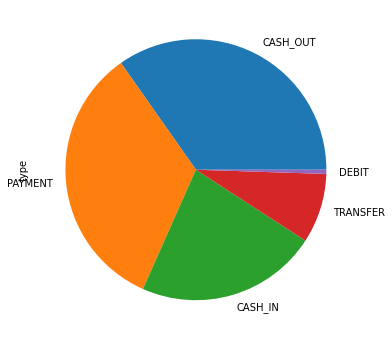

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
df['type'].value_counts().plot(kind='pie');

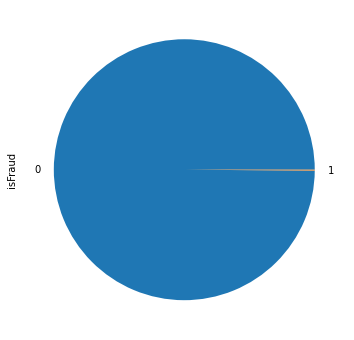

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
df['isFraud'].value_counts().plot(kind='pie');

In [9]:
df.groupby('isFraud').mean()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,
0,244.361662,1.748270e+05,8.543984e+05,879941.298869,1.111530e+06,1.229469e+06,0.0
1,222.800000,3.218608e+06,3.218608e+06,0.000000,3.487025e+04,1.103712e+06,0.0


In [10]:
correlation = df.corr()
print(correlation["isFraud"].sort_values(ascending=False))

isFraud           1.000000
amount            0.211754
oldbalanceOrg     0.025216
newbalanceDest   -0.000973
step             -0.004753
oldbalanceDest   -0.008647
newbalanceOrig   -0.009275
isFlaggedFraud         NaN
Name: isFraud, dtype: float64


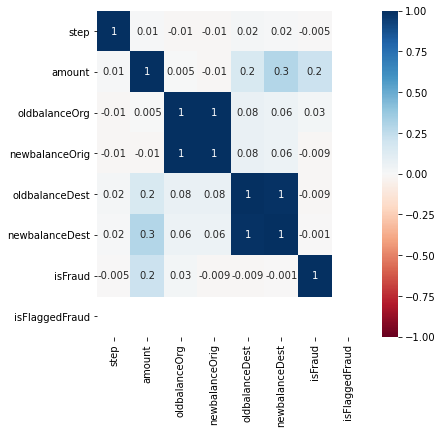

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True,fmt='.1g', cmap='RdBu', robust=True #center=True)
           );

### Random forest model uz pomoc Grid Search

In [12]:
df["type"] = df["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
# df["isFraud"] = df["isFraud"].map({0: "No Fraud", 1: "Fraud"})
print(df.head())

         step  type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
359565     17     3   412517.62  C1721152088          25.00       412542.62   
779997     39     1   192150.54   C294291851       82193.00            0.00   
608215     34     2    12711.53  C1644448426      245749.84       233038.31   
5286531   373     3    26087.53   C304560764    23257908.84     23283996.37   
3822228   282     4  1852451.39    C69947528           0.00            0.00   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
359565   C1244292009        49675.00            0.00        0               0  
779997    C596156911       258601.69       621976.40        0               0  
608215   M1726695580            0.00            0.00        0               0  
5286531   C643681155       539471.25       513383.72        0               0  
3822228    C99275333      6385805.08      8238256.47        0               0  


In [13]:
df["isFraud"].value_counts()

0    9990
1      10
Name: isFraud, dtype: int64

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
df['diffORG'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['diffDEST'] = df['newbalanceDest'] - df['oldbalanceDest']
x = np.array(df[["type", "amount", "oldbalanceOrg", "newbalanceOrig", 'diffDEST', 'diffORG', 'newbalanceDest', 'oldbalanceDest']])
y = np.array(df[["isFraud"]])
x, y = shuffle(x, y)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [16]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.999


In [17]:
# parameters for GridSearch
parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[200, 300], 'max_depth':[2,7], 'max_leaf_nodes':[2,15]}

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()
best_rf_model = GridSearchCV(rf_model, parameters)

In [19]:
#pokrecemo gridsearch
y_train = y_train.reshape(-1)
# best_rf_model.fit(x_train, y_train)

In [20]:
# sorted(best_rf_model.cv_results_.keys())

In [21]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",best_rf_model.best_estimator_)
# print("\n The best score across ALL searched params:\n",best_rf_model.best_score_)
# print("\n The best parameters across ALL searched params:\n",best_rf_model.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=7, max_leaf_nodes=15, n_estimators=200)

 The best score across ALL searched params:
 0.9987777777777778

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 15, 'n_estimators': 200}

### Plotovanje greske u zavinosti od hiperparametara modela

In [22]:
from sklearn import metrics

y_train = y_train.reshape(-1)
rf_model = RandomForestClassifier(max_depth=7, max_leaf_nodes = 15, n_estimators=200)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

print('precision: ', metrics.precision_score(y_test,y_pred))
print('recall: ', metrics.recall_score(y_test,y_pred))
print('f1: ', metrics.f1_score(y_test,y_pred))

precision:  0.0
recall:  0.0
f1:  0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# y_pred

### Pokusavamo oversampling

In [30]:
df['diffORG'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['diffDEST'] = df['newbalanceDest'] - df['oldbalanceDest']
x = np.array(df[["type", "amount", "oldbalanceOrg", "newbalanceOrig", 'diffDEST', 'diffORG', 'newbalanceDest', 'oldbalanceDest']])
y = np.array(df[["isFraud"]])
x, y = shuffle(x, y)

In [31]:
# import library
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

X_resampled, y_resampled = SMOTE().fit_resample(x, y)
# fit predictor and target variable
print('Original dataset shape', Counter(pd.Series(y.reshape(-1))))
print('Resample dataset shape', Counter(pd.Series(y_resampled.reshape(-1))))

Original dataset shape Counter({0: 9990, 1: 10})
Resample dataset shape Counter({0: 9990, 1: 9990})


In [49]:
df_resampled = pd.DataFrame(X_resampled, columns = ["type", "amount", "oldbalanceOrg", "newbalanceOrig", 'diffDEST', 'diffORG', 'newbalanceDest', 'oldbalanceDest'])
df_resampled['isFraud'] = pd.Series(y_resampled)

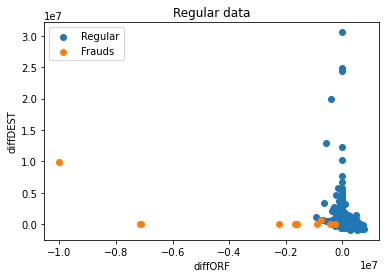

In [55]:
plt.scatter(df[df['isFraud']==0]['diffORG'], df[df['isFraud']==0]['diffDEST'], label = 'Regular')
plt.scatter(df[df['isFraud']==1]['diffORG'], df[df['isFraud']==1]['diffDEST'], label = 'Frauds')
plt.xlabel('diffORF')
plt.ylabel('diffDEST')
plt.title('Regular data')
plt.legend();

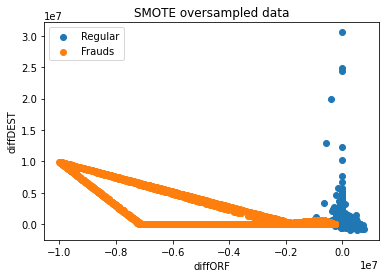

In [54]:
plt.scatter(df_resampled[df_resampled['isFraud']==0]['diffORG'], df_resampled[df_resampled['isFraud']==0]['diffDEST'], label = 'Regular')
plt.scatter(df_resampled[df_resampled['isFraud']==1]['diffORG'], df_resampled[df_resampled['isFraud']==1]['diffDEST'], label = 'Frauds')
plt.xlabel('diffORF')
plt.ylabel('diffDEST')
plt.title('SMOTE oversampled data')
plt.legend();

Uzimamo parametere za najbolji model iz grid search-a

In [71]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.10, random_state=42)
rf = RandomForestClassifier(max_depth=7, max_leaf_nodes=20, n_estimators=500)
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=7, max_leaf_nodes=20, n_estimators=500)

In [72]:
y_pred = rf.predict(x_test)

In [74]:
print('precision: ', round(metrics.precision_score(y_test,y_pred),4))
print('recall: ', round(metrics.recall_score(y_test,y_pred),4))
print('f1: ', round(metrics.f1_score(y_test,y_pred),4))
print('accuracy:', round(metrics.accuracy_score(y_test,y_pred),4))
print('roc_auc_score:', round(metrics.roc_auc_score(y_test,y_pred),4))

precision:  1.0
recall:  1.0
f1:  1.0
accuracy: 1.0
roc_auc_score: 1.0


Malo se igramo sa vizualizacijom potraga...

Text(0.5, 1.0, 'Precision i Recall vs Dubina drveta')

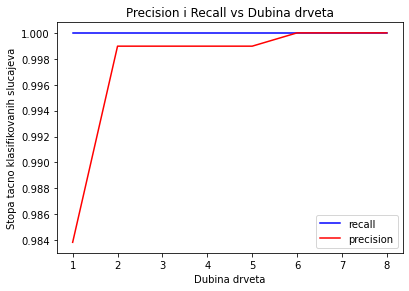

In [58]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

recall=[]
precision = []
max_depth = [1,2,3,4,5,6,7,8]

for depth in max_depth:
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_test)
    recall.append(metrics.recall_score(y_test,y_pred))
    precision.append(metrics.precision_score(y_test,y_pred))

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # velicina osa
# plotujemo ose
axes.plot(max_depth, recall, 'b', label='recall')
axes.plot(max_depth, precision, 'r', label='precision')
axes.legend()
axes.set_xlabel('Dubina drveta') # Notice the use of set_ to begin methods
axes.set_ylabel('Stopa tacno klasifikovanih slucajeva')
axes.set_title('Precision i Recall vs Dubina drveta')

Text(0.5, 1.0, 'Precision i Recall vs Broj listica')

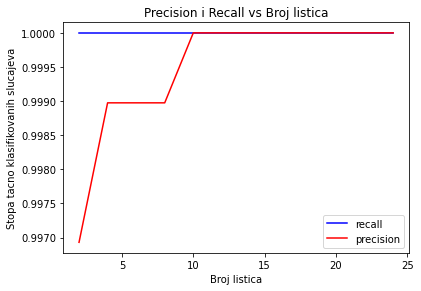

In [59]:
recall=[]
precision = []
max_leaf_nodes = [2,4,6,8,10,12,14,16,18,20,22,24]

for node in max_leaf_nodes:
    rf = RandomForestClassifier(max_leaf_nodes=node)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_test)
    recall.append(metrics.recall_score(y_test,y_pred))
    precision.append(metrics.precision_score(y_test,y_pred))

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # velicina osa
# plotujemo ose
axes.plot(max_leaf_nodes, recall, 'b', label='recall')
axes.plot(max_leaf_nodes, precision, 'r', label='precision')
axes.legend()
axes.set_xlabel('Broj listica') # Notice the use of set_ to begin methods
axes.set_ylabel('Stopa tacno klasifikovanih slucajeva')
axes.set_title('Precision i Recall vs Broj listica')

Text(0.5, 1.0, 'Precision i Recall vs Broj drveta')

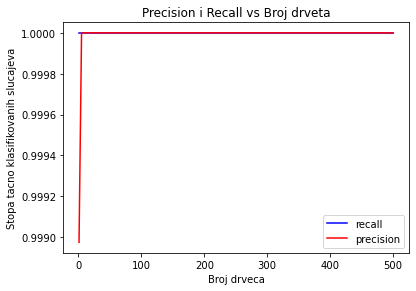

In [60]:
recall=[]
precision = []
broj_drveca = [1, 5,10,50,70, 100, 200, 300, 400, 500]

for drvo in broj_drveca:
    rf = RandomForestClassifier(n_estimators=drvo)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_test)
    recall.append(metrics.recall_score(y_test,y_pred))
    precision.append(metrics.precision_score(y_test,y_pred))

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # velicina osa
# plotujemo ose
axes.plot(broj_drveca, recall, 'b', label='recall')
axes.plot(broj_drveca, precision, 'r', label='precision')
axes.legend()
axes.set_xlabel('Broj drveca') # Notice the use of set_ to begin methods
axes.set_ylabel('Stopa tacno klasifikovanih slucajeva')
axes.set_title('Precision i Recall vs Broj drveta')

### Uzimamo drugu grupu podataka i isprobavamo model na njoj

Uzimamo 6 frauds i proveravamo da li ce ih smote oversemplovani model prepoznati

In [113]:
df = pd.read_csv('online_payment.csv')
df_2 = df[40000:50000].copy()

df_2["type"] = df_2["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
df_2['diffORG'] = df_2['newbalanceOrig'] - df_2['oldbalanceOrg']
df_2['diffDEST'] = df_2['newbalanceDest'] - df_2['oldbalanceDest']

print('ukupno prevara:', len(df_2[df_2['isFraud']==1]))

real_frauds = df_2[df_2['isFraud']==1]

real_frauds = real_frauds[["type", "amount", "oldbalanceOrg", "newbalanceOrig", 'diffDEST', 'diffORG', 'newbalanceDest', 'oldbalanceDest']]

ukupno prevara: 6


In [114]:
y_pred_real_frauds = rf.predict(np.array(real_frauds))

# SMOTE model je uspeo da uhvati 4 od 6 prevara!!!

In [115]:
y_pred_real_frauds

array([1, 0, 1, 1, 1, 0])

In [116]:
len(y_pred_real_frauds)

6

In [118]:
y_pred_real_frauds_proba = rf.predict_proba(np.array(real_frauds))
y_pred_real_frauds_proba[:,1]

array([0.52361054, 0.05814763, 0.98193414, 0.79662561, 0.97058152,
       0.16147441])

### Radimo to isto samo na drugom setu podataka. Provericemo da li model prepoznaje slucajave prevare (n=13)

In [119]:
df = pd.read_csv('online_payment.csv')
df_2 = df[20000:30000].copy()

df_2["type"] = df_2["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
df_2['diffORG'] = df_2['newbalanceOrig'] - df_2['oldbalanceOrg']
df_2['diffDEST'] = df_2['newbalanceDest'] - df_2['oldbalanceDest']

print('ukupno prevara:', len(df_2[df_2['isFraud']==1]))

real_frauds = df_2[df_2['isFraud']==1]

real_frauds = real_frauds[["type", "amount", "oldbalanceOrg", "newbalanceOrig", 'diffDEST', 'diffORG', 'newbalanceDest', 'oldbalanceDest']]

ukupno prevara: 3


In [120]:
y_pred_real_frauds = rf.predict(np.array(real_frauds))

In [122]:
y_pred_real_frauds

array([0, 0, 0])

In [123]:
y_pred_real_frauds_proba = rf.predict_proba(np.array(real_frauds))

In [125]:
y_pred_real_frauds_proba[:,1]

array([0.02, 0.  , 0.  ])

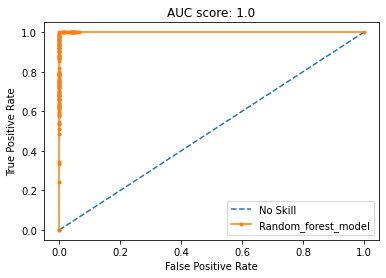

In [128]:
import matplotlib.pyplot as plt

y_pred_2_proba = rf.predict_proba(x_test)


pos_probs = y_pred_2_proba[:, 1]

roc_auc = metrics.roc_auc_score(y_test, pos_probs)
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = metrics.roc_curve(y_test, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Random_forest_model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title(f'AUC score: {round(roc_auc,3)}')
# show the plot
plt.show()

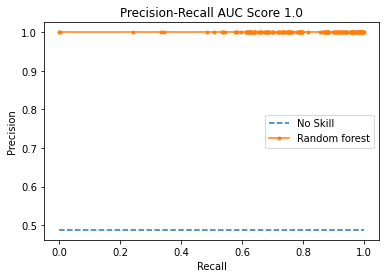

In [140]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


pos_probs = y_pred_2_proba[:, 1]

no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)

auc_score = auc(recall, precision)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Random forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'Precision-Recall AUC Score {round(auc_score,3)}')
# show the plot
plt.show()

### Kreiramo novi model sa tresholdom 0.2 kako nam nijedna prevara ne bi promakla ali sa rizikom da povecamo fp

In [134]:
threshold = 0.2

predicted_proba = rf.predict_proba(x_test)
y_pred_3 = (predicted_proba [:,1] >= threshold).astype('int')


In [135]:
print('precision: ', round(metrics.precision_score(y_test,y_pred_3),4))
print('recall: ', round(metrics.recall_score(y_test,y_pred_3),4))
print('f1: ', round(metrics.f1_score(y_test,y_pred_3),4))
print('accuracy:', round(metrics.accuracy_score(y_test,y_pred_3),4))
print('roc_auc_score:', round(metrics.roc_auc_score(y_test,y_pred_3),4))

precision:  0.999
recall:  1.0
f1:  0.9995
accuracy: 0.9995
roc_auc_score: 0.9995


### SVM model with penalty

The next tactic is to use penalized learning algorithms that increase the cost of classification
mistakes on the minority class.
A popular algorithm for this technique is Penalized-SVM.
During training, we can use the argument class_weight=’balanced’ to penalize mistakes
on the minority class by an amount proportional to how under-represented it is.
We also want to include the argument probability=True if we want to enable probability
estimates for SVM algorithms.
Let’s train a model using Penalized-SVM on the original imbalanced dataset:

In [136]:
# load library
from sklearn.svm import SVC
# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)
svc_model.fit(x_train, y_train)
svc_predict = svc_model.predict(x_test)# check performance
print('ROCAUC score:',metrics.roc_auc_score(y_test, svc_predict))
print('Accuracy score:',metrics.accuracy_score(y_test, svc_predict))
print('F1 score:',metrics.f1_score(y_test, svc_predict))

ROCAUC score: 0.99853515625
Accuracy score: 0.9984984984984985
F1 score: 0.9984623270117888


Let's try this on new chunk of data:

In [137]:
df_2 = pd.read_csv('online_payment.csv')
df_2 = shuffle(df_2)
df_2 = df_2[10000:20000].copy()

df_2["type"] = df_2["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})

df_2['diffORG'] = df_2['newbalanceOrig'] - df_2['oldbalanceOrg']
df_2['diffDEST'] = df_2['newbalanceDest'] - df_2['oldbalanceDest']
x = np.array(df_2[["type", "amount", "oldbalanceOrg", "newbalanceOrig", 'diffDEST', 'diffORG', 'newbalanceDest', 'oldbalanceDest']])
y = np.array(df_2[["isFraud"]])
x, y = shuffle(x, y)

In [138]:
y_pred_2 = svc_model.predict(x)

In [139]:
print('precision: ', round(metrics.precision_score(y,y_pred_2),2))
print('recall: ', round(metrics.recall_score(y,y_pred_2),2))
print('f1: ', round(metrics.f1_score(y,y_pred_2),2))
print('accuracy:', round(metrics.accuracy_score(y,y_pred_2),2))
print('roc_auc_score:', round(metrics.roc_auc_score(y,y_pred_2),2))

precision:  0.28
recall:  0.64
f1:  0.39
accuracy: 1.0
roc_auc_score: 0.82
